# Lecture: Feature Matching

## Section 1: Preparation

### Install the libraries

In [3]:
# Import the libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pyrealsense2 as rs2
import cv2

from matplotlib import cm
from matplotlib.ticker import LinearLocator


ModuleNotFoundError: No module named 'pyrealsense2'

In [ ]:
!pip install pyrealsense2

### Capture an image using realsense camera

In [ ]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('feature_matching1.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()


### Capture another image

In [ ]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('feature_matching2.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()

## Section 2: Ratio Testing for Feature Matching
Reference: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

### Display the two captured images

The captured images


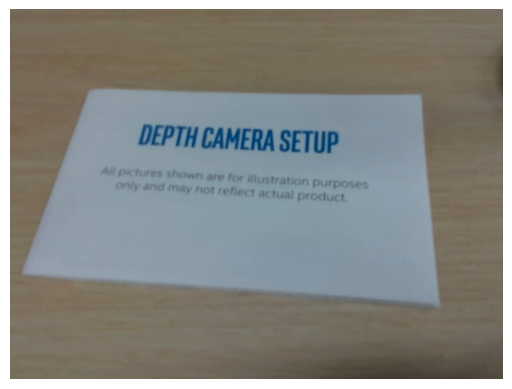

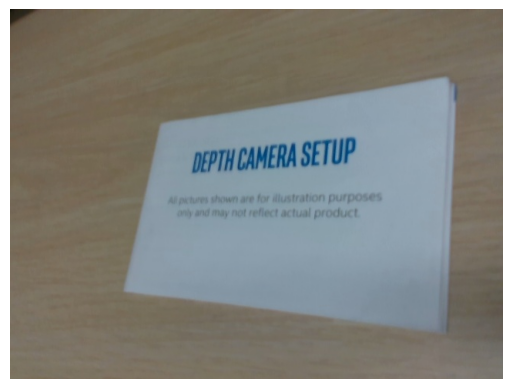

In [ ]:
# Load the image
try:
    img = Image.open('feature_matching1.jpg')
    img_array = np.array(img)
    # Split the image into RGB channels
    if img_array.shape[-1] != 3: # Check if the image has 3 channels (RGB)
      print("Error: The image does not appear to be an RGB image.")

    img2 = Image.open('feature_matching2.jpg')
    img_array2 = np.array(img2)
    print("The captured images")
    plt.axis("off")
    plt.imshow(img_array)
    plt.show()
    plt.axis("off")
    plt.imshow(img_array2)
    plt.show()


except FileNotFoundError:
    print("Error: The file photo.jpg was not found. Please make sure to capture an image first.")
except Exception as e:
    print(f"An error occurred: {e}")

### Convert them into grayscale

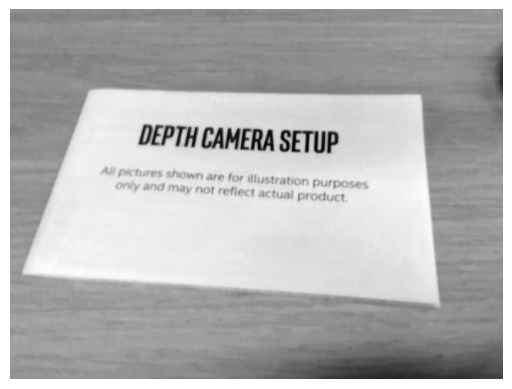

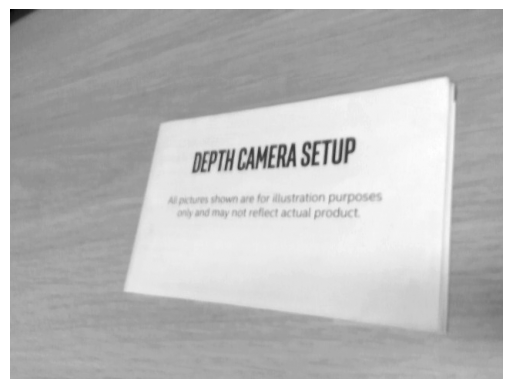

In [ ]:
# Convert the image into gray-scale format
img = Image.open('feature_matching1.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.show()

img = Image.open('feature_matching2.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.show()

### Extract out the features

In [ ]:
img1 = cv2.imread('feature_matching1.jpg',cv2.IMREAD_GRAYSCALE)          # queryImage
img1_color = cv2.imread('feature_matching1.jpg')
img2 = cv2.imread('feature_matching2.jpg',cv2.IMREAD_GRAYSCALE) # trainImage
img2_color = cv2.imread('feature_matching2.jpg')

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print("Statistics on the keypoints detecting from SIFT: ")
print("Number of points: " + str(len(kp1)))
print("Data type of the keypoints: " + str(type(kp1[0])))
print("Number of points: " + str(len(kp2)))
print("Data type of the keypoints: " + str(type(kp2[0])))
print("Feature Descriptions: ")
print(des1.shape)
print(des2.shape)
# drawKeypoints(input_image, keypoints, output_image)
img1_sift = cv2.drawKeypoints(img1,kp1,img1_color)

cv2.imshow("Sift features extracted from the first image", img1_sift)
cv2.waitKey(0)
cv2.destroyAllWindows()

Statistics on the keypoints detecting from SIFT: 
Number of points: 215
Data type of the keypoints: <class 'cv2.KeyPoint'>
Number of points: 145
Data type of the keypoints: <class 'cv2.KeyPoint'>
Feature Descriptions: 
(215, 128)
(145, 128)


### Find the top nearest neighbors
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html

In [ ]:
from sklearn.neighbors import KDTree
k = 2
img1_sift_tree = KDTree(des1)
img2_sift_tree = KDTree(des2)

img1_matched_dist, img1_matched = img2_sift_tree.query(des1, k=2, return_distance=True)
img2_matched_dist, img2_matched = img1_sift_tree.query(des2, k=2, return_distance=True)
print("Number of matches: ")
print(img1_matched.shape)
print(img2_matched.shape)
print("A sample of detected matches: ")
print(img1_matched[0])

Number of matches: 
(215, 2)
(145, 2)
A sample of detected matches: 
[ 6 79]


In [ ]:
### Draw out the raw matches

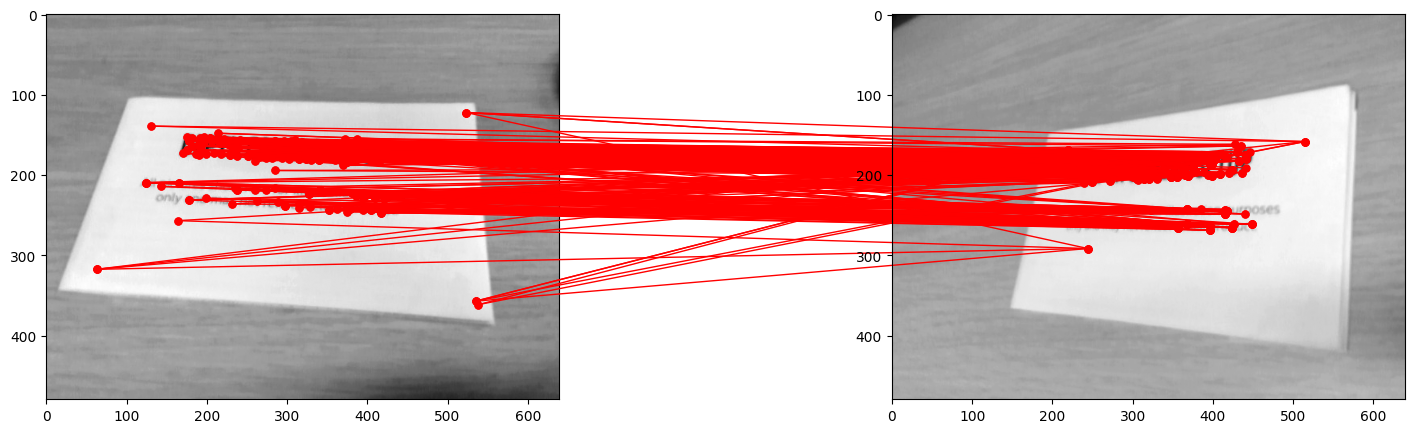

In [ ]:
from matplotlib.patches import ConnectionPatch
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


img1_kp_x = []
img1_kp_y = []
img1_kp = []
for i in range(len(kp1)):
    img1_kp_x.append(kp1[i].pt[0])
    img1_kp_y.append(kp1[i].pt[1])
    img1_kp.append((kp1[i].pt[0], kp1[i].pt[1]))
img1_kp = np.array(img1_kp)

img2_kp_0 = []
img2_kp_1 = []

for i in range(len(kp1)):
    pt = kp2[img1_matched[i][0]].pt
    img2_kp_0.append((pt[0], pt[1]))
    pt = kp2[img1_matched[i][1]].pt
    img2_kp_1.append((pt[0], pt[1]))
img2_kp_0 = np.array(img2_kp_0)
img2_kp_1 = np.array(img2_kp_1)
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

for i in range(len(kp1)):
    con = ConnectionPatch(xyA=(img1_kp[i][0], img1_kp[i][1]), xyB=(img2_kp_0[i][0], img2_kp_0[i][1]), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red")
    ax2.add_artist(con)
ax1.plot(img1_kp_x, img1_kp_y,'ro',markersize=5)
ax2.plot(img2_kp_0[:, 0], img2_kp_0[:, 1],'ro',markersize=5)

for i in range(len(kp1)):
    con = ConnectionPatch(xyA=(img1_kp[i][0], img1_kp[i][1]), xyB=(img2_kp_1[i][0], img2_kp_1[i][1]), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red")

    ax2.add_artist(con)
ax1.plot(img1_kp_x, img1_kp_y,'ro',markersize=5)
ax2.plot(img2_kp_1[:, 0], img2_kp_1[:, 1],'ro',markersize=5)


plt.show()

### Nearest Neighbor Search with Ratio testing

92


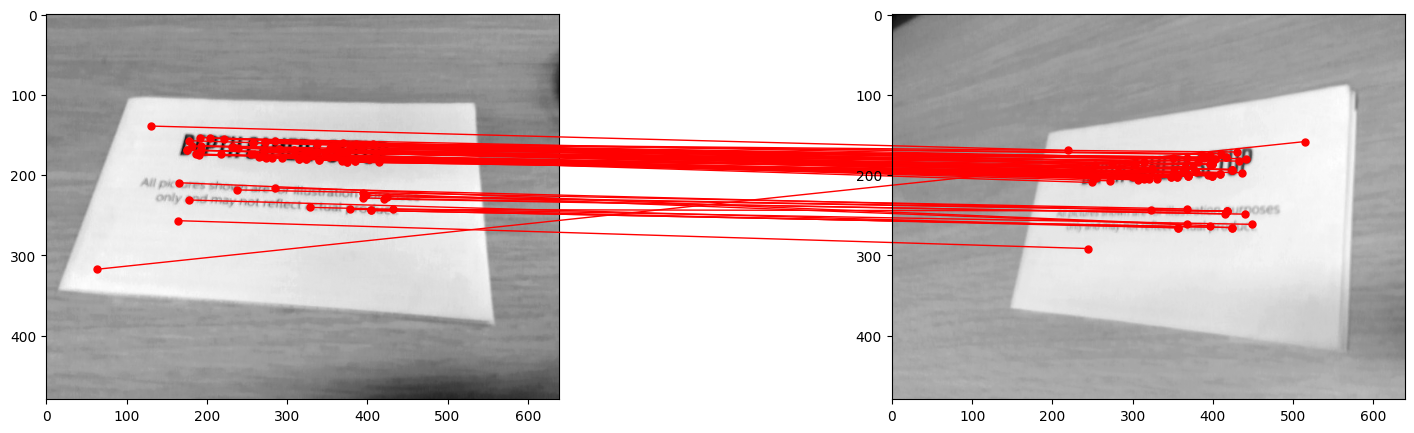

In [ ]:
img1_matched_keep_idx = []

for i in range(len(kp1)):
    if img1_matched_dist[i][0] < 0.75 * img1_matched_dist[i][1]:
        img1_matched_keep_idx.append(i)
img1_kp_keep = img1_kp[img1_matched_keep_idx]
img2_kp_0_keep = img2_kp_0[img1_matched_keep_idx]

N = img1_kp_keep.shape[0]
print(N)
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

for i in range(N):
    con = ConnectionPatch(xyA=(img1_kp_keep[i][0], img1_kp_keep[i][1]), xyB=(img2_kp_0_keep[i][0], img2_kp_0_keep[i][1]), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red")
    ax2.add_artist(con)
ax1.plot(img1_kp_keep[:, 0], img1_kp_keep[:, 1],'ro',markersize=5)
ax2.plot(img2_kp_0_keep[:, 0], img2_kp_0_keep[:, 1],'ro',markersize=5)



plt.show()

In [ ]:
### Matching in a reverse way

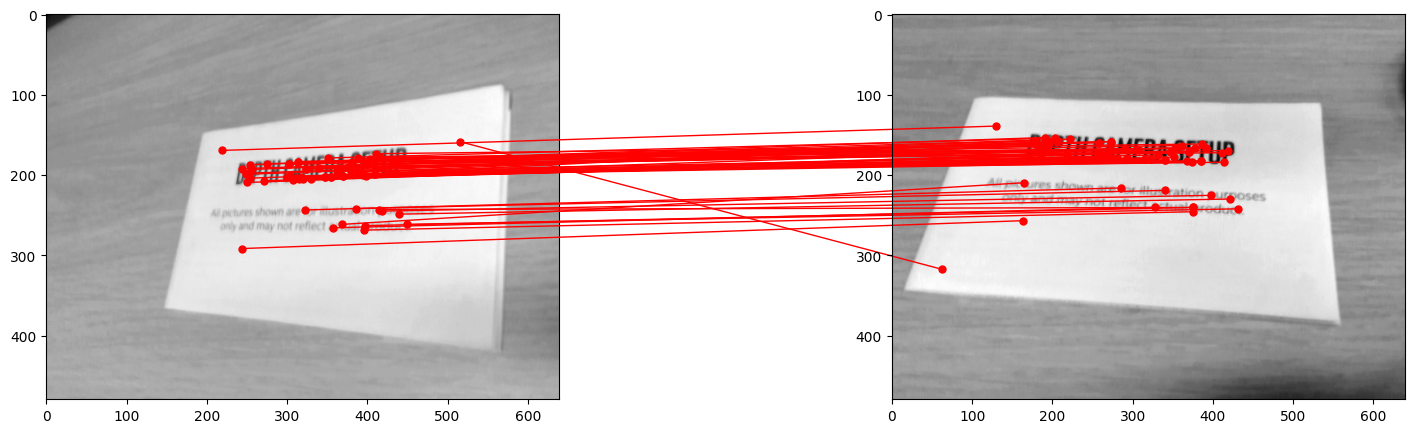

In [ ]:
# Apply ratio testing on the match from image1 to image2
img2_kp = []
for i in range(len(kp2)):
    img2_kp.append((kp2[i].pt[0], kp2[i].pt[1]))
img2_kp = np.array(img2_kp)

img1_kp_0 = []
img1_kp_1 = []

for i in range(len(kp2)):
    pt = kp1[img2_matched[i][0]].pt
    img1_kp_0.append((pt[0], pt[1]))
    pt = kp1[img2_matched[i][1]].pt
    img1_kp_1.append((pt[0], pt[1]))
img1_kp_0 = np.array(img1_kp_0)
img1_kp_1 = np.array(img1_kp_1)

# Ratio testing
img2_matched_keep_idx = []

for i in range(len(kp2)):
    if img2_matched_dist[i][0] < 0.75 * img2_matched_dist[i][1]:
        img2_matched_keep_idx.append(i)
img2_kp_keep = img2_kp[img2_matched_keep_idx]
img1_kp_0_keep = img1_kp_0[img2_matched_keep_idx]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img2, cmap="gray")
ax2.imshow(img1, cmap="gray")
N = img2_kp_keep.shape[0]
for i in range(N):
    con = ConnectionPatch(xyA=(img2_kp_keep[i][0], img2_kp_keep[i][1]), xyB=(img1_kp_0_keep[i][0], img1_kp_0_keep[i][1]), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red")
    ax2.add_artist(con)
ax1.plot(img2_kp_keep[:, 0], img2_kp_keep[:, 1],'ro',markersize=5)
ax2.plot(img1_kp_0_keep[:, 0], img1_kp_0_keep[:, 1],'ro',markersize=5)



plt.show()


In [ ]:
### Bi-directional Checking

92


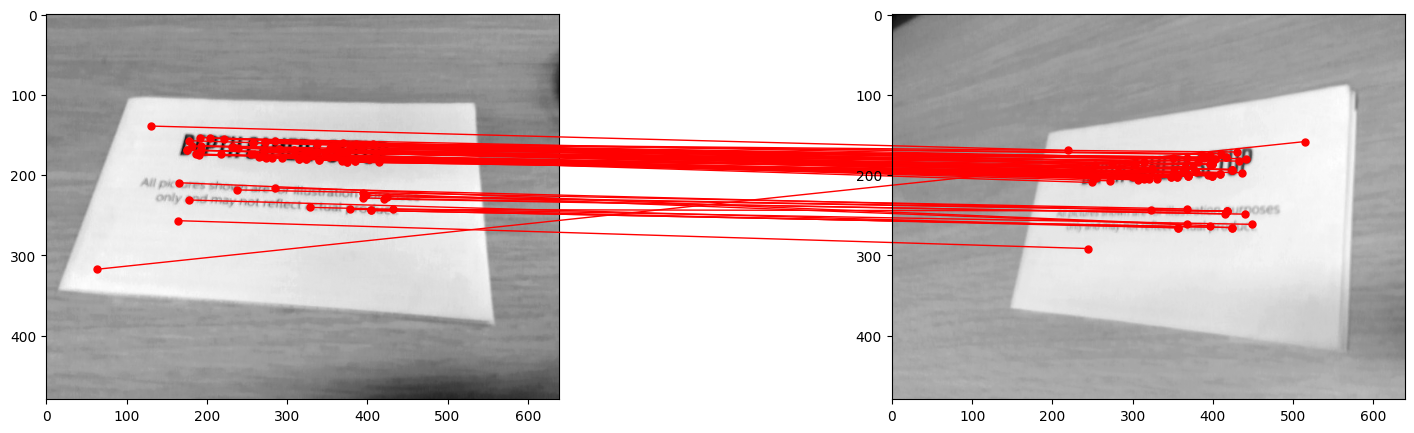

In [ ]:
# Filter out the invalid ones & Maintain the good ones
des1_keep = des1[img1_matched_keep_idx]
des2_keep = des2[img2_matched_keep_idx]

des1_tree_keep = KDTree(des1_keep)
des2_tree_keep = KDTree(des2_keep)
img1_matched_keep = img1_matched[img1_matched_keep_idx]
img2_matched_keep = img2_matched[img2_matched_keep_idx]

bi_directional_check = []
def dist(v1, v2):
    return v1[0]-v2[0]**2 + (v1[1]-v2[1])**2

th = 1

for i in range(des1_keep.shape[0]):
    # The detected feature point in image 1
    kp_img1 = img1_kp_keep[i]

    # The matched keypoint in image 2
    kp_matched_img2_idx = img1_matched_keep[i][0]

    # The feature of the corresponding point
    kp_feat_matched_img2 = des2[kp_matched_img2_idx]

    # The point of the closest feature in image1
    kp_matched_img1_idx = des1_tree_keep.query(kp_feat_matched_img2.reshape(1, -1), return_distance=False)[0][0]


    if dist(img1_kp_keep[kp_matched_img1_idx], kp_img1) < th:
        bi_directional_check.append(i)


img1_kp_keep_bi = img1_kp_keep[bi_directional_check]
img2_kp_0_keep_bi = img2_kp_0_keep[bi_directional_check]

N = img1_kp_keep_bi.shape[0]
print(N)
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

for i in range(N):
    con = ConnectionPatch(xyA=(img1_kp_keep_bi[i][0], img1_kp_keep_bi[i][1]), xyB=(img2_kp_0_keep_bi[i][0], img2_kp_0_keep_bi[i][1]), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red")
    ax2.add_artist(con)
ax1.plot(img1_kp_keep_bi[:, 0], img1_kp_keep_bi[:, 1],'ro',markersize=5)
ax2.plot(img2_kp_0_keep_bi[:, 0], img2_kp_0_keep_bi[:, 1],'ro',markersize=5)



plt.show()


In [ ]:
## Section 3: OpenCV Implementation

### Practical codes by using the library from OpenCV
Find the matches from image1 to image2

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
print("Statistics of keypoint matching: ")
print("Number of total matches: " + str(len(matches)))
print("Number of detected matches for each keypoint: " + str(len(matches[0])))
img_no_ratio = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matched SIFT features w/o ratio testing", img_no_ratio)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img_ratio = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matched SIFT features w/ ratio testing", img_ratio)
cv2.waitKey(0)
cv2.destroyAllWindows()

Statistics of keypoint matching: 
Number of total matches: 215
Number of detected matches for each keypoint: 2


113

Similarly, we can find the matches from image2 to image1

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des2,des1,k=2)
print("Statistics of keypoint matching: ")
print("Number of total matches: " + str(len(matches)))
print("Number of detected matches for each keypoint: " + str(len(matches[0])))
img_no_ratio = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matched SIFT features w/o ratio testing", img_no_ratio)
cv2.waitKey(0)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img_ratio = cv2.drawMatchesKnn(img2,kp2,img1,kp1,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matched SIFT features w/ ratio testing", img_ratio)
cv2.waitKey(0)
cv2.destroyAllWindows()

Statistics of keypoint matching: 
Number of total matches: 839
Number of detected matches for each keypoint: 2


-1